## Instructions
Using the "Normal_Squares_Toggleable_sharon" notebook, replace the "calculate_square_corners" function call in "create_dense_squares" function with "calculate_square_corners1", "calculate_square_corners2", or "calculate_square_corners3" to test patches drawn using the respective alternative definitions, and re-run the notebook to get results.

Alternative definitions of covering the epithelium width include:
1. At least two opposite corners are outside epithelium
2. At least two points on opposite sides of patch are outside epithelium
3. At least two points on any two sides of patch are outside epithelium

In [8]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds

def get_new_imgs(file_path):
    image1=cv2.imread(file_path)
    padding_size = 500
    height, width = image1.shape[:2]
    new_height = height + 2 * padding_size
    new_width = width + 2 * padding_size

    new_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    new_image[padding_size:padding_size+height, padding_size:padding_size+width] = image1

    image1_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    _,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)

    return new_image, whole_thresh

In [9]:
def find_contours(binary_image):
    '''find relevant contours of an image'''
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = []
    # we want to take the contour if it's a donut  or if it's an island 
    for idx, contour in enumerate(contours):
        child = hierarchy[0][idx][2]
        parent = hierarchy[0][idx][3]
        if child != -1 and hierarchy[0][child][0] == -1 and hierarchy[0][child][1] == -1: # donut: (immediate child, no siblings)
            valid_contours.append(contour)
        elif child == -1 and parent == -1: # island (no parents or children)
            valid_contours.append(contour)
            
    return tuple(valid_contours)

def draw_contours(binary_image):
    contours = find_contours(binary_image)
    all_points = [[0, 0]]
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points = np.array(contour.reshape(-1,2))
        all_points = np.concatenate((all_points, points))
    plt.imshow(binary_image, aspect='equal')
    plt.scatter(np.array(all_points)[:,0], np.array(all_points)[:,1], c='red', marker='o', s = 1)
    plt.show()

def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    #Loop to find variable length
    if variable_length:
        i=square_size
        while True:
            #Increase i while extending into cell
            test_point=point-(normal*i).astype(int)
            test_point=np.clip(test_point,0,np.array(binary_image.shape[:2])[::-1] - 1)

            if binary_image[test_point[1],test_point[0]]==0:
                break
            #if i>=1024:
            #    break #Maximum square size as to not be huge
            i+=2

        extended_length=i
        half_size=i//2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,square_size=128,step=5,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares=[]


    #Loop over all contours 
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1,2)
        n_points=len(points)
        squares=[]

        #Find corners at step length
        for i in range(0,n_points,step):
            corners,length=calculate_square_corners(points[i],contour_normals[i],square_size,binary_image,variable_length)

            if length>=2048 or length<16: #Trying to avoid badly sized squares
                continue

            squares.append(corners)

        all_squares.append(squares)
    return all_squares

def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[0]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened = [square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list = []

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares = []

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found = False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap = calculate_square_overlap(square, other_square)
                        if overlap > overlap_thresh:
                            overlap_found = True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result

def process_contours(image,binary_image,square_size=128,step=5,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        square_size (int): Base size of squares
        step (int): Points to skip between squares
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    
    normals=calculate_contour_normals(contours,smoothing_size)
    squares_list=create_dense_squares(
        contours,normals,binary_image,
        square_size=square_size,
        step=step,
        variable_length=variable_length
    )
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )
    
    result = draw_squares(image,final_squares_list)
    plt.imshow(result)
    
    return result, contours, final_squares_list

In [10]:
# Different definitions of defining "covers epithelium width"
# Current definition: point opposite of tangent point along contour is outside epithelium

# Alternative definition 1: At least two opposite corners are outside epithelium
def calculate_square_corners1(point, normal, square_size, binary_image, variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent = np.array([-normal[1], normal[0]])
    half_size = square_size // 2
    extended_length = square_size

    # Loop to find variable length
    if variable_length:
        i = square_size
        while True:
            # Calculate the corners of the square
            corners = np.array([
                point + (tangent * (i // 2)),
                point - (tangent * (i // 2)),
                point - (tangent * (i // 2)) - (normal * i),
                point + (tangent * (i // 2)) - (normal * i)
            ]).astype(int)

            # Clip corners to stay within image bounds
            corners = np.clip(corners, 0, np.array(binary_image.shape[:2])[::-1] - 1)

            # Check if at least two opposite corners are outside the epithelium
            if (binary_image[corners[0][1], corners[0][0]] == 0 and binary_image[corners[2][1], corners[2][0]] == 0) or \
               (binary_image[corners[1][1], corners[1][0]] == 0 and binary_image[corners[3][1], corners[3][0]] == 0):
                break

            i += 2

        extended_length = i
        half_size = i // 2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

# Alternative definition 2: At least two points on opposite sides of patch are outside epithelium
def calculate_square_corners2(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    # Loop to find variable length
    if variable_length:
        i = square_size
        while True:
            # Calculate the corners of the square
            corners = np.array([
                point + (tangent * (i // 2)),
                point - (tangent * (i // 2)),
                point - (tangent * (i // 2)) - (normal * i),
                point + (tangent * (i // 2)) - (normal * i)
            ]).astype(int)

            # Clip corners to stay within image bounds
            corners = np.clip(corners, 0, np.array(binary_image.shape[:2])[::-1] - 1)

            # Check if there is at least one point on two opposite sides that are 0
            side1 = [corners[0], corners[1]]
            side2 = [corners[2], corners[3]]
            if any(binary_image[pt[1], pt[0]] == 0 for pt in side1) and any(binary_image[pt[1], pt[0]] == 0 for pt in side2):
                break

            i += 2

        extended_length = i
        half_size = i // 2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

# Alternative definition 3: At least two points on any two sides of patch are outside epithelium
def calculate_square_corners3(point, normal, square_size, binary_image, variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent = np.array([-normal[1], normal[0]])
    half_size = square_size // 2
    extended_length = square_size

    # Loop to find variable length
    if variable_length:
        i = square_size
        while True:
            # Calculate the corners of the square
            corners = np.array([
                point + (tangent * (i // 2)),
                point - (tangent * (i // 2)),
                point - (tangent * (i // 2)) - (normal * i),
                point + (tangent * (i // 2)) - (normal * i)
            ]).astype(int)

            # Clip corners to stay within image bounds
            corners = np.clip(corners, 0, np.array(binary_image.shape[:2])[::-1] - 1)

            # Check points along the sides of the square
            side1_points = [point + (tangent * (i // 2)) - (normal * j) for j in range(0, i + 1, 2)]
            side2_points = [point - (tangent * (i // 2)) - (normal * j) for j in range(0, i + 1, 2)]
            side3_points = [point + (tangent * j) - (normal * (i // 2)) for j in range(0, i + 1, 2)]
            side4_points = [point - (tangent * j) - (normal * (i // 2)) for j in range(0, i + 1, 2)]

            side1_points = np.clip(side1_points, 0, np.array(binary_image.shape[:2])[::-1] - 1).astype(int)
            side2_points = np.clip(side2_points, 0, np.array(binary_image.shape[:2])[::-1] - 1).astype(int)
            side3_points = np.clip(side3_points, 0, np.array(binary_image.shape[:2])[::-1] - 1).astype(int)
            side4_points = np.clip(side4_points, 0, np.array(binary_image.shape[:2])[::-1] - 1).astype(int)

            if (any(binary_image[pt[1], pt[0]] == 0 for pt in side1_points) and any(binary_image[pt[1], pt[0]] == 0 for pt in side2_points)) or \
               (any(binary_image[pt[1], pt[0]] == 0 for pt in side3_points) and any(binary_image[pt[1], pt[0]] == 0 for pt in side4_points)):
                break

            i += 2

        extended_length = i
        half_size = i // 2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

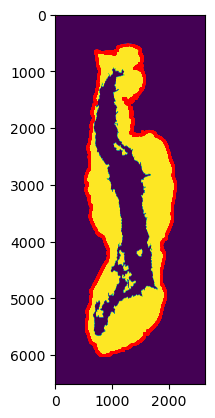

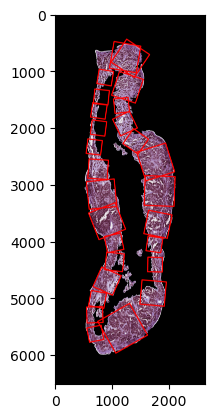

In [11]:
new_image, whole_thresh = get_new_imgs("testing_slices/h2114153  h&e_ROI_1 Epithelia.png") 
draw_contours(whole_thresh)
result_image, contour, squares = process_contours(
     new_image,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

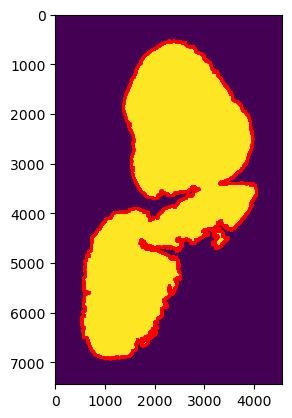

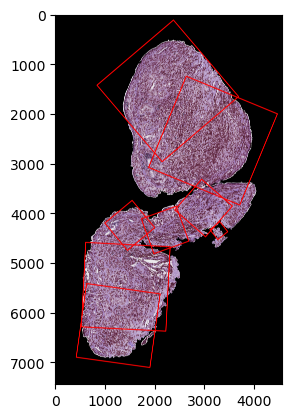

In [12]:
new_image, whole_thresh = get_new_imgs("testing_slices/h2114160 h&e_ROI_1 Epithelia.png") 
draw_contours(whole_thresh)

result_image2, contour2, squares2 = process_contours(
     new_image,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

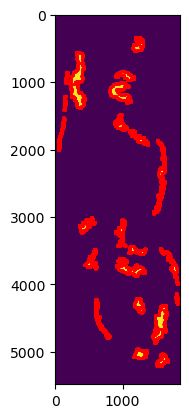

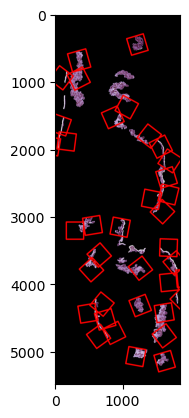

In [13]:
image3=cv2.imread("testing_slices/h2114154  h&e_ROI_4 Epithelia.png")
image3_gray = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
_,whole_thresh3=cv2.threshold(image3_gray,1,255,cv2.THRESH_BINARY)

draw_contours(whole_thresh3)
result_image3, contour3, squares3 = process_contours(
     image3,
     whole_thresh3,
     square_size=256,
     step=10,
     overlap_thresh=0.1,
     smoothing_size=10,
     look_back=30,
     second_pass=True,
     variable_length=True)

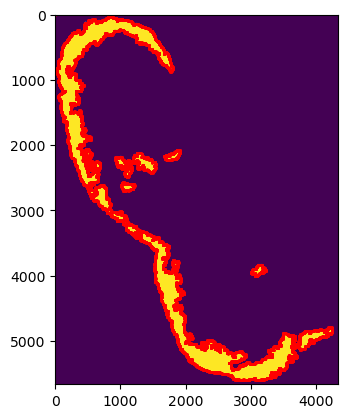

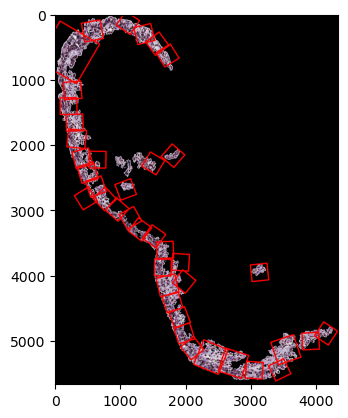

In [14]:
image4=cv2.imread("testing_slices/h2114155 h&e_ROI_1 Epithelia.png")
image4_gray = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
_,whole_thresh4=cv2.threshold(image4_gray,1,255,cv2.THRESH_BINARY)

draw_contours(whole_thresh4)
result_image4, contour4, squares4 = process_contours(
     image4,
     whole_thresh4,
     square_size=256,
     step=10,
     overlap_thresh=0.1,
     smoothing_size=20,
     look_back=30,
     second_pass=True,
     variable_length=True)

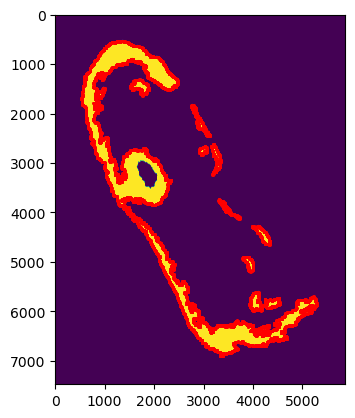

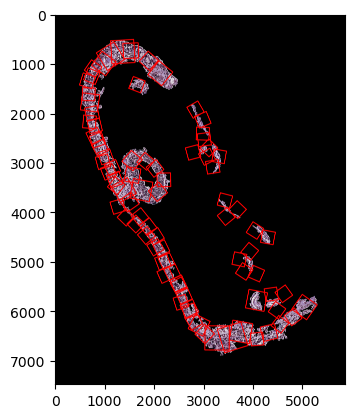

In [15]:
new_image, whole_thresh = get_new_imgs("testing_slices/h2114155 h&e_ROI_2 Epithelia.png") 
draw_contours(whole_thresh)
result_image, contour, squares = process_contours(
     new_image,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)